## Carga de Librerías

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
from IPython import display


# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Establecer GPU por defecto en caso de estar disponible

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Descarga del dataset

Dataset de audio que consiste en grabaciones de dígitos hablados del 0 al 9 por 5 personas diferentes.

In [2]:
# Load dataset and its info
dataset, info = tfds.load(
    'spoken_digit',
    split='train',
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)

# Get class names from the metadata
label_names = info.features['label'].names

print("Class names:", label_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.J00W3A_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [34]:
data: list[np.array, int] = [(np.array(x[0]), int(x[1]))  for x in list(dataset)]

unique_labels = set(label for _, label in data)
print("Etiquetas únicas:", unique_labels)

Etiquetas únicas: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Separación train/validación

In [26]:
train_size = int(0.8 * len(data))
train_ds = data[:train_size]
val_ds = data[train_size:]

print("Train:", len(train_ds))
print("Validación:", len(val_ds))

Train: 2000
Validación: 500


## EDA

In [33]:
print(len(data[1][0]))
data[1][1]

2929


1

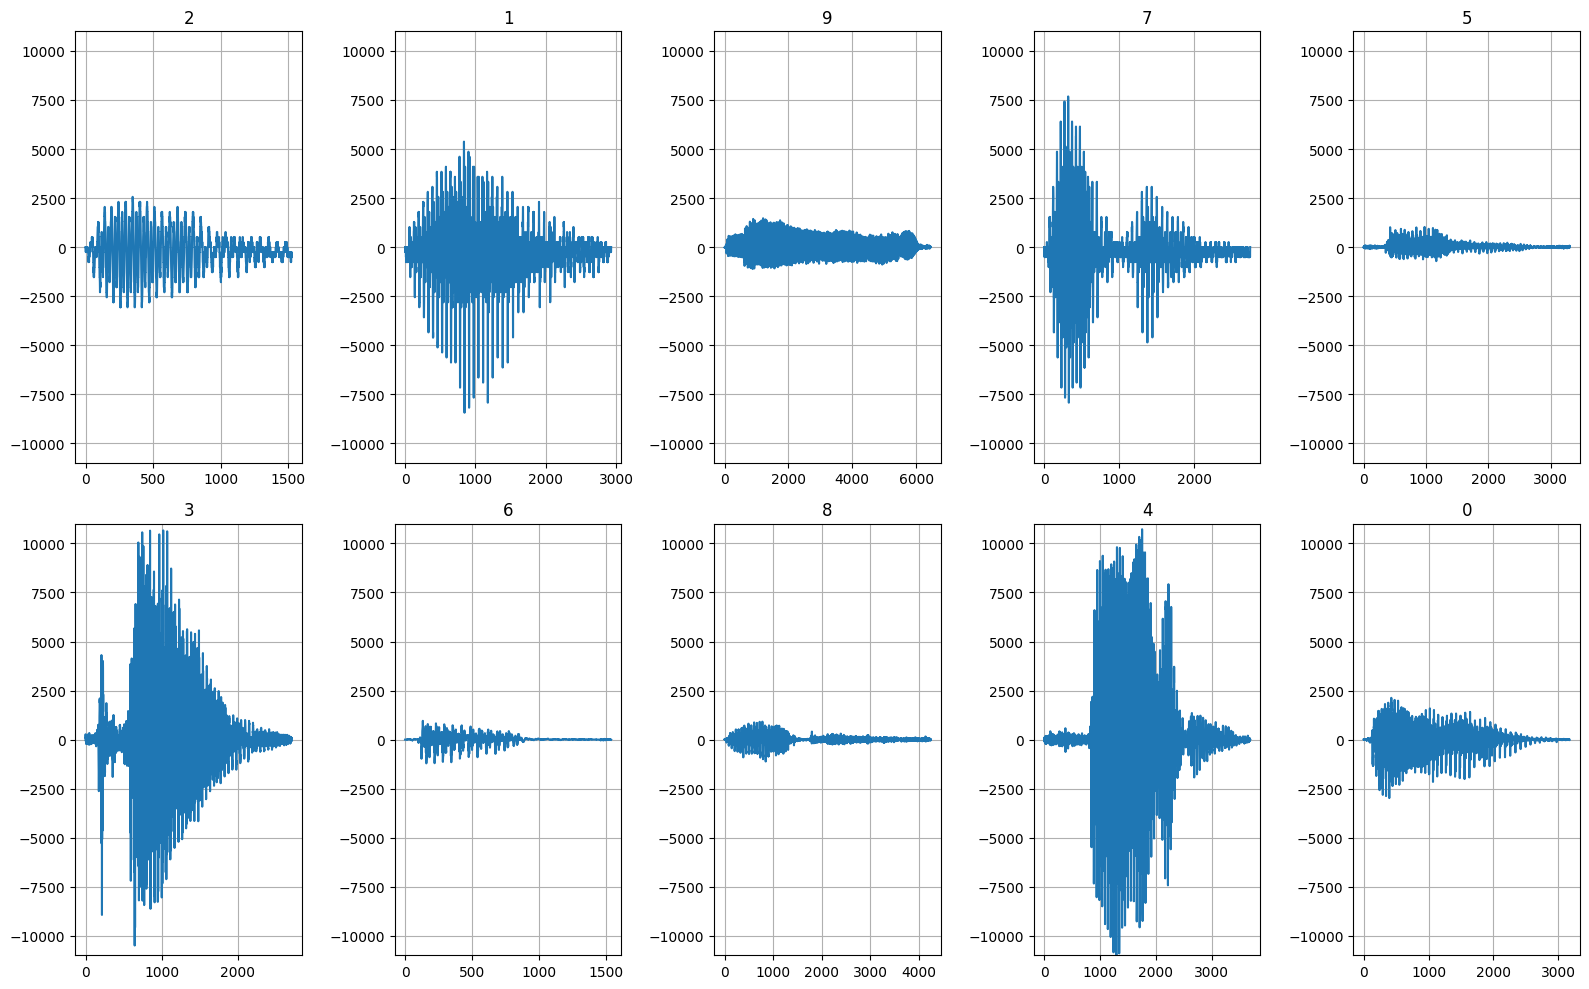

In [37]:
# Diccionario para guardar un ejemplo por clase
examples_per_class = {}

# Recorrer el dataset hasta encontrar un ejemplo por cada clase
for audio, label in train_ds:
    label_val = label
    if label_val not in examples_per_class:
        examples_per_class[label_val] = audio
    # Salimos cuando tenemos ejemplos de todas las clases
    if len(examples_per_class) == len(label_names):
        break

# Graficar
plt.figure(figsize=(16, 10))
rows = 2
cols = 5

for i, (label_val, audio_signal) in enumerate(examples_per_class.items()):
    plt.subplot(rows, cols, i+1)
    plt.plot(audio_signal)
    plt.ylim([-11000, 11000])
    plt.title(label_names[label_val])
    plt.grid(True)

plt.tight_layout()
plt.show()

## Conversión formas de ondas a espectogramas

In [38]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [43]:
# Loop through the first 3 examples in the training dataset
for i in range(5):
    # Get the next audio-label pair from the dataset iterator
    audio, label = train_ds[i]

    # The 'audio' variable already contains the waveform as a NumPy array
    waveform = audio

    # Convert the NumPy array waveform to a TensorFlow Tensor
    spectrogram = get_spectrogram(tf.convert_to_tensor(waveform, dtype=tf.float32)) # Ensure correct dtype for STFT

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    # Display the audio using the original waveform
    display.display(display.Audio(waveform, rate=16000))

Label: 2
Waveform shape: (1525,)
Spectrogram shape: (10, 129, 1)
Audio playback


Label: 1
Waveform shape: (2929,)
Spectrogram shape: (21, 129, 1)
Audio playback


Label: 9
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 9
Waveform shape: (3360,)
Spectrogram shape: (25, 129, 1)
Audio playback


Label: 7
Waveform shape: (2746,)
Spectrogram shape: (20, 129, 1)
Audio playback


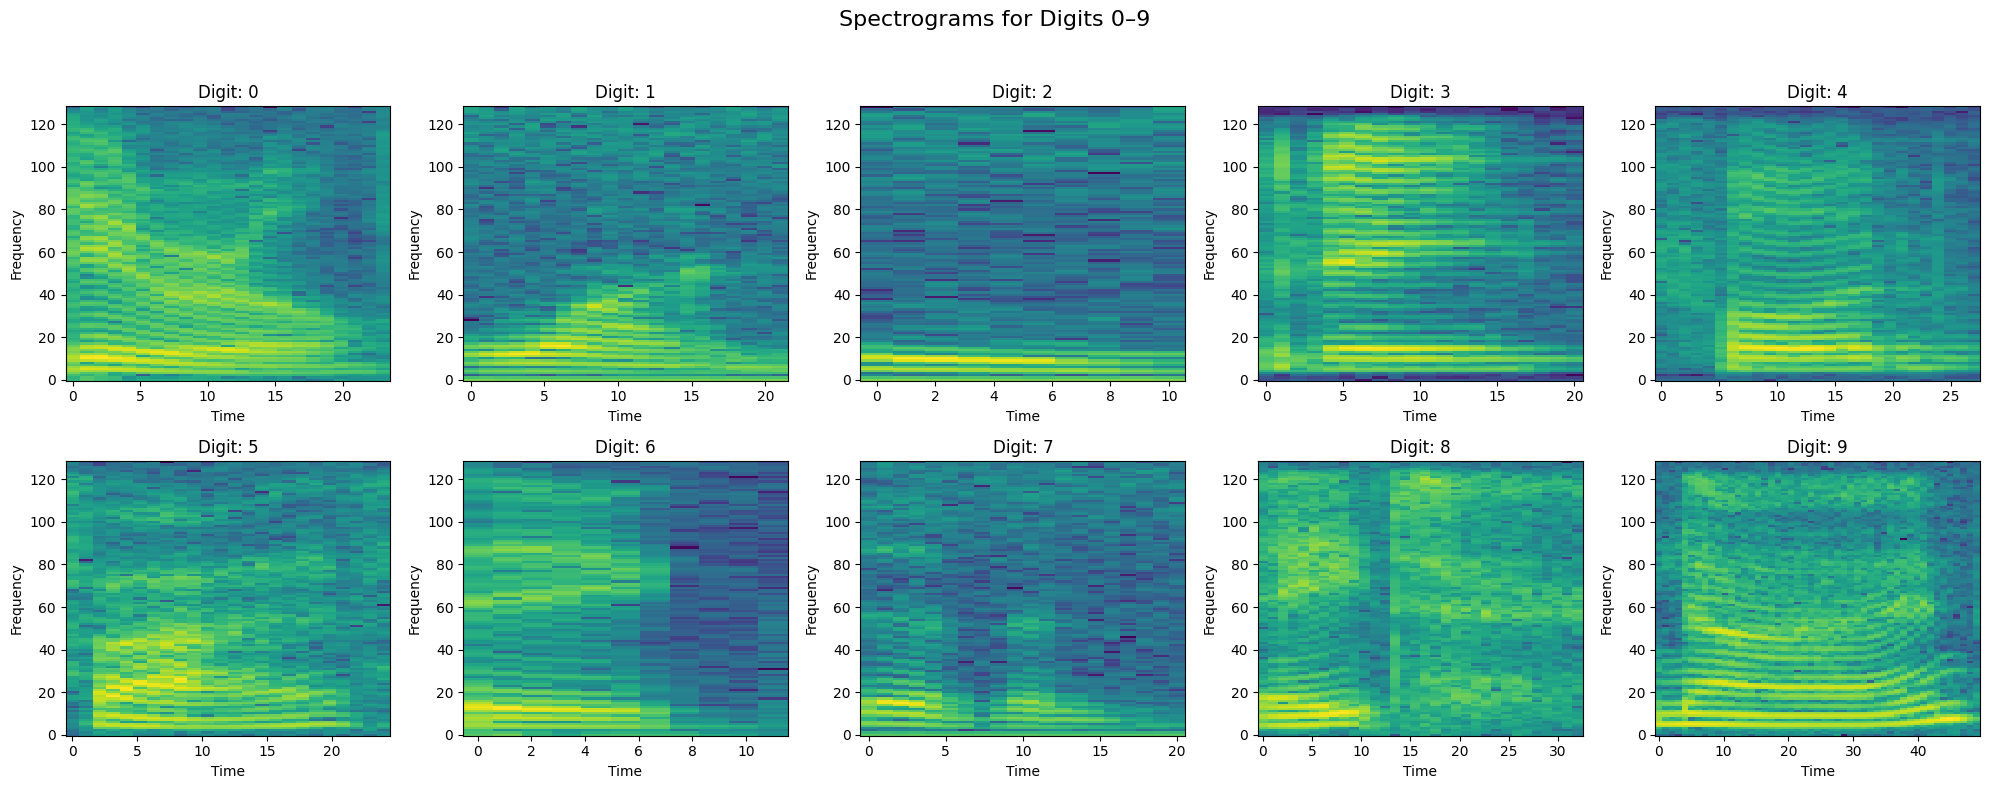

In [57]:
examples_per_class = {}
for audio, label in train_ds:
    if label not in examples_per_class:
        examples_per_class[label] = audio
    if len(examples_per_class) == len(label_names):
        break


def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]  # Add channel dimension
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) == 3:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height, width = log_spec.shape
    X = np.linspace(0, spectrogram.shape[0], num=width)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")

# --- Plot spectrograms for each class ---
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (label, waveform) in enumerate(sorted(examples_per_class.items())):
    spectrogram = get_spectrogram(tf.convert_to_tensor(waveform, dtype=tf.float32)).numpy()
    ax = axes[idx]
    plot_spectrogram(spectrogram, ax)
    ax.set_title(f"Digit: {label_names[label]}")

plt.suptitle("Spectrograms for Digits 0–9", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [104]:
def convert_dataset_to_image(dataset: list[np.array, int]) -> list[np.array, int]:
  image_dataset: list = []
  for audio, label in dataset:
    #print(audio)
    spectrogram = get_spectrogram(tf.convert_to_tensor(audio, dtype=tf.float32)).numpy()
    #print(spectrogram.shape)
    #print(spectrogram[3])

    tuple_for_dataset = (spectrogram, label)
    image_dataset.append(tuple_for_dataset)
  return image_dataset

image_train_dataset = convert_dataset_to_image(train_ds)
image_val_dataset = convert_dataset_to_image(val_ds)

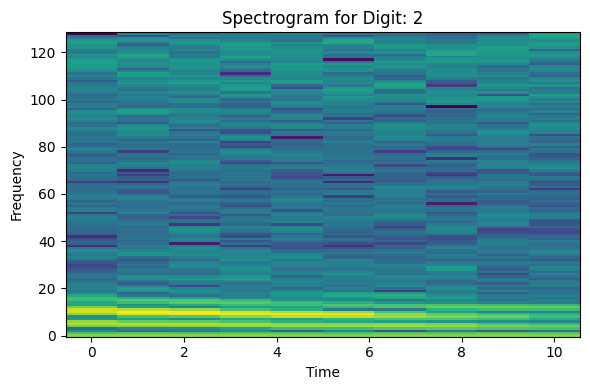

In [120]:
# Get the human-readable label name
label_value = image_train_dataset[0][1]

# Get the original waveform for the first example from the training dataset
# Remember that image_train_dataset was created from train_ds
original_waveform = train_ds[0][0]

# --- Plot the single spectrogram ---
fig, ax = plt.subplots(figsize=(6, 4)) # Create a single figure and a single Axes object

# Compute the spectrogram from the original waveform
spectrogram_to_plot = get_spectrogram(tf.convert_to_tensor(original_waveform, dtype=tf.float32))

# Plot the computed spectrogram
plot_spectrogram(spectrogram_to_plot.numpy(), ax) # Pass the spectrogram data and the Axes object

ax.set_title(f"Spectrogram for Digit: {label_names[label_value]}")
# You already set x and y labels inside plot_spectrogram, so no need to repeat
plt.tight_layout()
plt.show()

In [130]:
# Obtener shape correcto de una imagen espectrograma
example_image = image_train_dataset[0][0]
print("Ejemplo de espectrograma shape:", example_image.shape)  # (n_frames, n_freq_bins, 1)

input_shape = example_image.shape
num_labels = len(label_names)

# Convertir lista de tuplas a tensores para poder usar Normalization.adapt
train_images = np.array([x for x, _ in image_train_dataset])
val_images = np.array([x for x, _ in image_val_dataset])

# Crear capa de normalización
norm_layer = layers.Normalization()

# Adaptar normalización a los datos de entrenamiento
norm_layer.adapt(train_images)

# Crear modelo CNN
model = models.Sequential([
    layers.Input(shape=input_shape),         # (altura, ancho, canales)
    norm_layer,                              # Normalización por canal
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Ejemplo de espectrograma shape: (10, 129, 1)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2000,) + inhomogeneous part.